In [51]:
import momepy
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from libpysal.weights import Queen, Rook, KNN
%matplotlib inline

In [103]:
df = gpd.read_file('final_test.shp')

In [104]:
df = df.reset_index()[['index', 'geometry']]
df = df.rename(columns={'index': 'ID'})

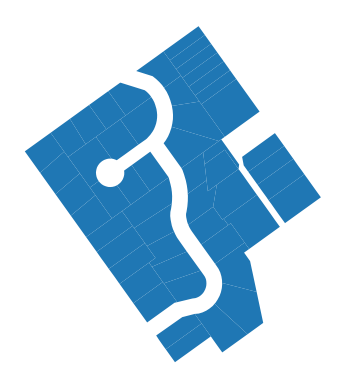

In [105]:
ax = df.plot()
ax.set_axis_off()

In [106]:
crs = df.estimate_utm_crs().to_epsg()
df = df.to_crs(crs)

# preprocess


In [107]:
#df_clean = momepy.preprocess(df, size=30,
#                              compactness=0.3, islands=True, loops=5)

In [57]:
#df_clean.plot()

# limit set at 1

In [108]:
buffer = 16

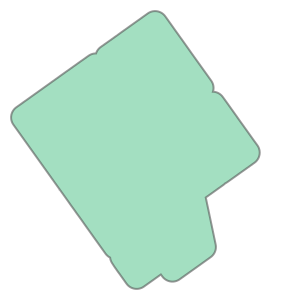

In [109]:
limit = momepy.buffered_limit(df, buffer=buffer)
limit

In [110]:
tessellation = momepy.Tessellation(df, unique_id='ID', limit=limit)

Inward offset...
Generating input point array...
Generating Voronoi diagram...
Generating GeoDataFrame...
Dissolving Voronoi polygons...


In [111]:
tessellation_gdf = tessellation.tessellation
tessellation_gdf = tessellation_gdf.reset_index(drop=True)

In [112]:
tessellation_gdf['ID'] = tessellation_gdf.index

In [113]:
tessellation_gdf.head()

,ID,geometry
0,0,"POLYGON ((481612.666 4399647.783, 481614.117 4..."
1,1,"POLYGON ((481594.222 4399664.291, 481598.486 4..."
2,2,"POLYGON ((481583.035 4399693.515, 481583.113 4..."
3,3,"POLYGON ((481560.281 4399705.347, 481569.666 4..."
4,4,"POLYGON ((481558.061 4399725.827, 481559.147 4..."


In [114]:
rook = Rook.from_dataframe(tessellation_gdf)

In [115]:
all_ids = rook.id_order
islands = rook.islands


In [116]:
# drop from gdf
#tessellation_gdf = tessellation_gdf.drop(islands)

In [117]:
#tessellation_gdf.to_file(f'tessellation_{buffer}_wdev2.shp')

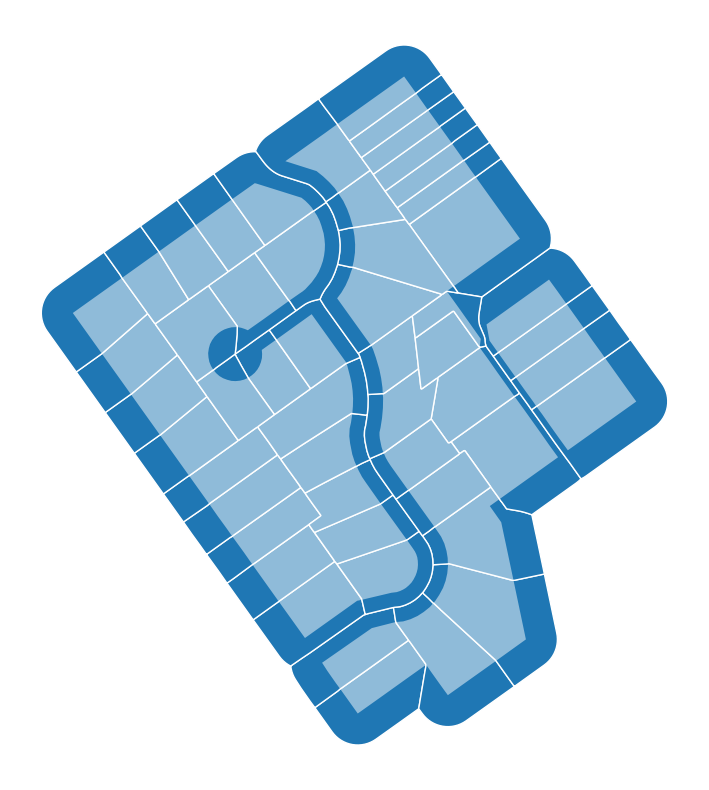

In [118]:
f, ax = plt.subplots(figsize=(10, 10))
tessellation_gdf.plot(ax=ax, edgecolor='white')
df.plot(ax=ax, color='white', alpha=.5)
ax.set_axis_off()
plt.show()

In [119]:
tessellation_gdf.to_file(f'tessellation_{buffer}_wdev2.shp')

In [101]:
# remove islands from the list of all ids
all_ids = [x for x in all_ids if x not in islands]



In [102]:
for i in all_ids:
    print(f'ID: {i}: {rook.neighbors[i]}')

ID: 3: [4]
ID: 4: [3, 5]
ID: 5: [4]


In [71]:
tessellation_gdf.head()

,ID,geometry
0,0,"POLYGON ((481635.089 4399502.459, 481635.059 4..."
1,1,"POLYGON ((481623.221 4399636.626, 481623.292 4..."
2,2,"POLYGON ((481614.117 4399649.069, 481614.542 4..."
3,3,"POLYGON ((481642.049 4399683.161, 481642.422 4..."
4,4,"POLYGON ((481583.035 4399693.515, 481583.113 4..."


In [72]:
# get component labels
components = rook.component_labels

combined_polygons = tessellation_gdf.dissolve(by=components)

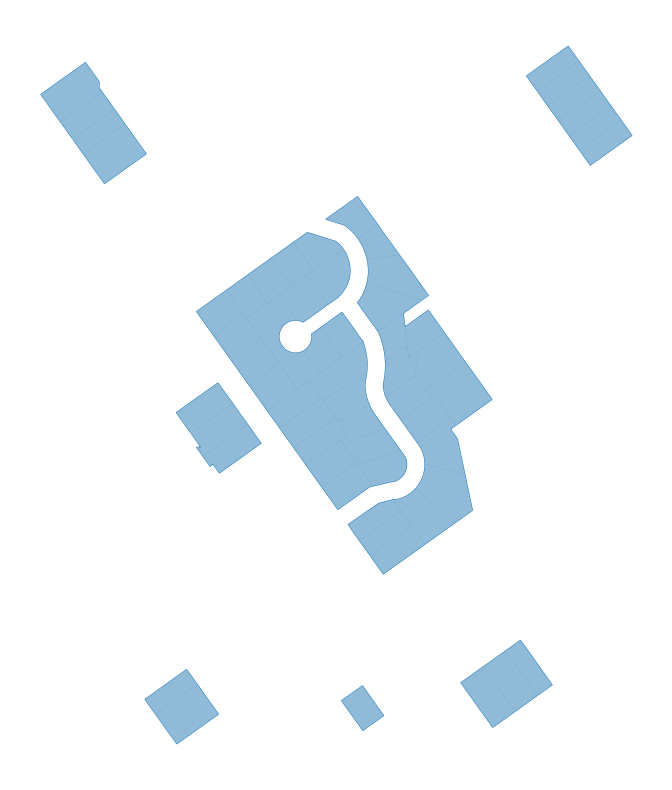

In [73]:
f, ax = plt.subplots(figsize=(10, 10))
combined_polygons.plot(ax=ax, edgecolor='white')
df.plot(ax=ax, color='white', alpha=.5)
ax.set_axis_off()
plt.show()

In [74]:
combined_polygons.to_file(f'combined_polygons_{buffer}_wdev2.shp')

In [75]:
combined_polygons_sindex = combined_polygons.sindex

In [76]:
def get_distance(df, offset):
    for poly in range(len(df)):
        ID = df.iloc[poly].ID
        # Calcualtes distance for each point from each df. If Point resides along edge of df( within 1-meter), distance is is given NUll then dropped
        df[f'd_to_{ID}'] = (df.apply(lambda x: 
                                                df.iloc[poly].geometry.distance(x['geometry']) 
                                                if df.iloc[poly].geometry.distance(x['geometry']) < offset 
                                                else 0, axis=1)
                                                )
    
    return df

In [77]:
combined_polygons_d = get_distance(combined_polygons, offset=20.0)

In [78]:
combined_polygons_d

,geometry,ID,d_to_0,d_to_1,d_to_4,d_to_10,d_to_12,d_to_20,d_to_43,d_to_54
0,"POLYGON ((481635.089 4399502.459, 481635.059 4...",0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0
1,"POLYGON ((481669.145 4399644.884, 481634.474 4...",1,0.0,0.000000,12.955754,0.0,0.000000,0.0,0.0,0.0
2,"POLYGON ((481555.293 4399729.957, 481550.856 4...",4,0.0,12.955754,0.000000,0.0,18.080759,0.0,0.0,0.0
3,"POLYGON ((481479.409 4399529.315, 481479.412 4...",10,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0
4,"POLYGON ((481527.294 4399737.959, 481531.733 4...",12,0.0,0.000000,18.080759,0.0,0.000000,0.0,0.0,0.0
5,"POLYGON ((481744.381 4399505.419, 481744.381 4...",20,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0
6,"POLYGON ((481423.468 4399990.705, 481427.908 4...",43,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0
7,"POLYGON ((481837.701 4399993.591, 481842.055 4...",54,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0


In [79]:
df = combined_polygons_d

In [89]:
# locate where distance is not 0
df.loc[:, (df != 0).any(axis=0)]


,geometry,ID,d_to_1,d_to_4,d_to_12
0,"POLYGON ((481635.089 4399502.459, 481635.059 4...",0,0.000000,0.000000,0.000000
1,"POLYGON ((481669.145 4399644.884, 481634.474 4...",1,0.000000,12.955754,0.000000
2,"POLYGON ((481555.293 4399729.957, 481550.856 4...",4,12.955754,0.000000,18.080759
3,"POLYGON ((481479.409 4399529.315, 481479.412 4...",10,0.000000,0.000000,0.000000
4,"POLYGON ((481527.294 4399737.959, 481531.733 4...",12,0.000000,18.080759,0.000000
5,"POLYGON ((481744.381 4399505.419, 481744.381 4...",20,0.000000,0.000000,0.000000
6,"POLYGON ((481423.468 4399990.705, 481427.908 4...",43,0.000000,0.000000,0.000000
7,"POLYGON ((481837.701 4399993.591, 481842.055 4...",54,0.000000,0.000000,0.000000
